In [126]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    set_seed
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import json
import os
import warnings
warnings.filterwarnings('ignore')

In [128]:
set_seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cuda


In [171]:
df = pd.read_csv('support_tickets.csv')  # Replace with your CSV file path

print("Dataset shape:", df.shape)
print("\nLabel distribution:")
print(df['label'].value_counts())

# Basic text preprocessing
def clean_text(text):
    text = str(text).lower().strip()
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

df['text_clean'] = df['text'].apply(clean_text)

# Check text length distribution
df['text_length'] = df['text_clean'].str.len()
print(f"\nText length stats:")
print(f"Mean: {df['text_length'].mean():.1f}")
print(f"Min: {df['text_length'].min()}")
print(f"Max: {df['text_length'].max()}")
print(f"Median: {df['text_length'].median():.1f}")

# Show examples
print(" Sample Examples ")
for label in df['label'].unique():
    print(f"\n{label.upper()} Examples:")
    samples = df[df['label'] == label]['text_clean'].head(2).tolist()
    for i, text in enumerate(samples, 1):
        print(f"{i}. {text}")

Dataset shape: (300, 2)

Label distribution:
label
billing      100
technical    100
other        100
Name: count, dtype: int64

Text length stats:
Mean: 78.0
Min: 44
Max: 129
Median: 77.0
 Sample Examples 

BILLING Examples:
1. my credit card was declined for payment, but the details are correct. can you assist?
2. "i'm having trouble understanding the charges on my invoice. can you explain them?

TECHNICAL Examples:
1. the sound on my tv is distorted when i watch certain channels. any solutions?
2. my smart thermostat isn't connecting to the app, making it impossible to adjust settings remotely.

OTHER Examples:
1. i'm getting error messages when trying to make a payment. is there an issue with the payment gateway?
2. i'm having difficulty applying the discount code at checkout. any tips?


In [130]:
class SmallDatasetOptimizer(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Create label mapping
        unique_labels = sorted(list(set(labels)))
        self.label2id = {label: idx for idx, label in enumerate(unique_labels)}
        self.id2label = {idx: label for label, idx in self.label2id.items()}
        print(f"Label mapping: {self.label2id}")
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize with optimal settings for small dataset
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            add_special_tokens=True
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.label2id[label], dtype=torch.long)
        }

# Optimized data split for small dataset
texts = df['text_clean'].tolist()
labels = df['label'].tolist()

# Use 70-15-15 split to maximize training data
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training samples: {len(X_train)} ({len(X_train)/len(texts)*100:.1f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(texts)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(texts)*100:.1f}%)")

# Check class distribution in splits
for split_name, split_labels in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    unique, counts = np.unique(split_labels, return_counts=True)
    print(f"{split_name} distribution: {dict(zip(unique, counts))}")

Training samples: 210 (70.0%)
Validation samples: 45 (15.0%)
Test samples: 45 (15.0%)
Train distribution: {np.str_('billing'): np.int64(70), np.str_('other'): np.int64(70), np.str_('technical'): np.int64(70)}
Val distribution: {np.str_('billing'): np.int64(15), np.str_('other'): np.int64(15), np.str_('technical'): np.int64(15)}
Test distribution: {np.str_('billing'): np.int64(15), np.str_('other'): np.int64(15), np.str_('technical'): np.int64(15)}


In [172]:
# model_name = "microsoft/DialoGPT-medium"  # Alternative: "distilbert-base-uncased"
# # For even better results with small data, try: "sentence-transformers/all-MiniLM-L6-v2"

# Let's use DistilBERT but with optimized settings
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create datasets
train_dataset = SmallDatasetOptimizer(X_train, y_train, tokenizer, max_length=128)
val_dataset = SmallDatasetOptimizer(X_val, y_val, tokenizer, max_length=128)
test_dataset = SmallDatasetOptimizer(X_test, y_test, tokenizer, max_length=128)

# Get label mappings
label2id = train_dataset.label2id
id2label = train_dataset.id2label
num_labels = len(label2id)

print(f"Number of labels: {num_labels}")
print(f"ID to label mapping: {id2label}")

from transformers import AutoConfig

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    dropout=0.3,  # This sets dropout for DistilBERT
    attention_dropout=0.3,  # This sets attention dropout for DistilBERT
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Label mapping: {'billing': 0, 'other': 1, 'technical': 2}
Label mapping: {'billing': 0, 'other': 1, 'technical': 2}
Label mapping: {'billing': 0, 'other': 1, 'technical': 2}
Number of labels: 3
ID to label mapping: {0: 'billing', 1: 'other', 2: 'technical'}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 66,955,779


In [173]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, predictions)
    
    # Per-class metrics
    per_class_f1 = f1_score(labels, predictions, average=None, zero_division=0)
    
    metrics = {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
    
    # Add per-class F1 scores
    for i, class_f1 in enumerate(per_class_f1):
        metrics[f'f1_class_{id2label[i]}'] = class_f1
    
    return metrics


In [179]:

from sklearn.metrics import f1_score, precision_recall_fscore_support

# Optimized training arguments for small dataset
training_args = TrainingArguments(
    output_dir='./results_optimized',
    num_train_epochs=40,  # More epochs for small dataset
    per_device_train_batch_size=4,  # Small batch size
    per_device_eval_batch_size=8,
    learning_rate=3e-5,  # Higher learning rate
    warmup_steps=20,  # Minimal warmup
    weight_decay=0.1,  # Higher weight decay for regularization
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=3,
    seed=42,
    dataloader_drop_last=False,
    remove_unused_columns=False,
    gradient_accumulation_steps=4,  # Effective batch size = 16
    lr_scheduler_type="cosine",  # Better for small datasets
    warmup_ratio=0.1,
    fp16=True if device.type == 'cuda' else False,  # Mixed precision if GPU
    dataloader_num_workers=0,  # Avoid multiprocessing issues
    report_to=None  # Disable wandb
)


In [180]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        # Calculate class weights
        class_counts = torch.bincount(torch.tensor([label2id[l] for l in y_train]))
        class_weights = 1.0 / class_counts.float()
        class_weights = class_weights / class_weights.sum() * len(class_weights)
        class_weights = class_weights.to(device)
        
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(logits.view(-1, num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

# Initialize optimized trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("✅ Optimized training setup complete!")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")

✅ Optimized training setup complete!
Effective batch size: 16


In [181]:
print("🚀 Starting optimized training for small dataset...")
print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples")

# Train the model
training_output = trainer.train()


🚀 Starting optimized training for small dataset...
Training on 210 samples, validating on 45 samples


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Class Billing,F1 Class Other,F1 Class Technical
1,No log,0.569433,0.777778,0.739967,0.838384,0.777778,0.909091,0.500000,0.810811
2,No log,0.563604,0.777778,0.739967,0.838384,0.777778,0.909091,0.500000,0.810811
3,No log,0.553223,0.777778,0.739967,0.838384,0.777778,0.909091,0.500000,0.810811
4,No log,0.536960,0.777778,0.739967,0.838384,0.777778,0.909091,0.500000,0.810811
5,0.532900,0.517381,0.777778,0.739967,0.838384,0.777778,0.909091,0.500000,0.810811
6,0.532900,0.497707,0.777778,0.739967,0.838384,0.777778,0.909091,0.500000,0.810811
7,0.532900,0.477922,0.777778,0.739967,0.838384,0.777778,0.909091,0.500000,0.810811
8,0.532900,0.468640,0.800000,0.771284,0.849206,0.800000,0.909091,0.571429,0.833333
9,0.532900,0.447380,0.800000,0.771284,0.849206,0.800000,0.909091,0.571429,0.833333
10,0.394600,0.406847,0.822222,0.800866,0.861111,0.822222,0.909091,0.636364,0.857143


In [182]:
print(f"\n📊 Training completed!")
print(f"Final training loss: {training_output.training_loss:.4f}")
print(f"Training time: {training_output.metrics['train_runtime']:.1f} seconds")



📊 Training completed!
Final training loss: 0.1977
Training time: 83.0 seconds


In [183]:
model_save_path = "./support_ticket_classifier_optimized"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"✅ Model saved to: {model_save_path}")

✅ Model saved to: ./support_ticket_classifier_optimized


In [184]:
print("📊 VALIDATION SET EVALUATION:")
val_results = trainer.evaluate(val_dataset)
for key, value in val_results.items():
    if 'eval_' in key:
        print(f"{key.replace('eval_', '')}: {value:.4f}")

📊 VALIDATION SET EVALUATION:


loss: 0.2845
accuracy: 0.8889
f1: 0.8852
precision: 0.8913
recall: 0.8889
f1_class_billing: 0.9032
f1_class_other: 0.8148
f1_class_technical: 0.9375
runtime: 0.1150
samples_per_second: 391.1790
steps_per_second: 8.6930


In [154]:
print("\n📊 TEST SET EVALUATION:")
test_results = trainer.evaluate(test_dataset)
for key, value in test_results.items():
    if 'eval_' in key:
        print(f"{key.replace('eval_', '')}: {value:.4f}")


📊 TEST SET EVALUATION:
loss: 0.2259
accuracy: 0.9333
f1: 0.9314
precision: 0.9400
recall: 0.9333
f1_class_billing: 0.9677
f1_class_other: 0.8889
f1_class_technical: 0.9375
runtime: 0.1192
samples_per_second: 377.5070
steps_per_second: 8.3890


In [185]:
test_predictions = trainer.predict(test_dataset)
y_pred = np.argmax(test_predictions.predictions, axis=1)
y_true = test_predictions.label_ids

In [186]:
y_pred_labels = [id2label[pred] for pred in y_pred]
y_true_labels = [id2label[true] for true in y_true]

In [188]:

print("\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_true_labels, y_pred_labels))


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     billing       0.94      1.00      0.97        15
       other       1.00      0.80      0.89        15
   technical       0.88      1.00      0.94        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



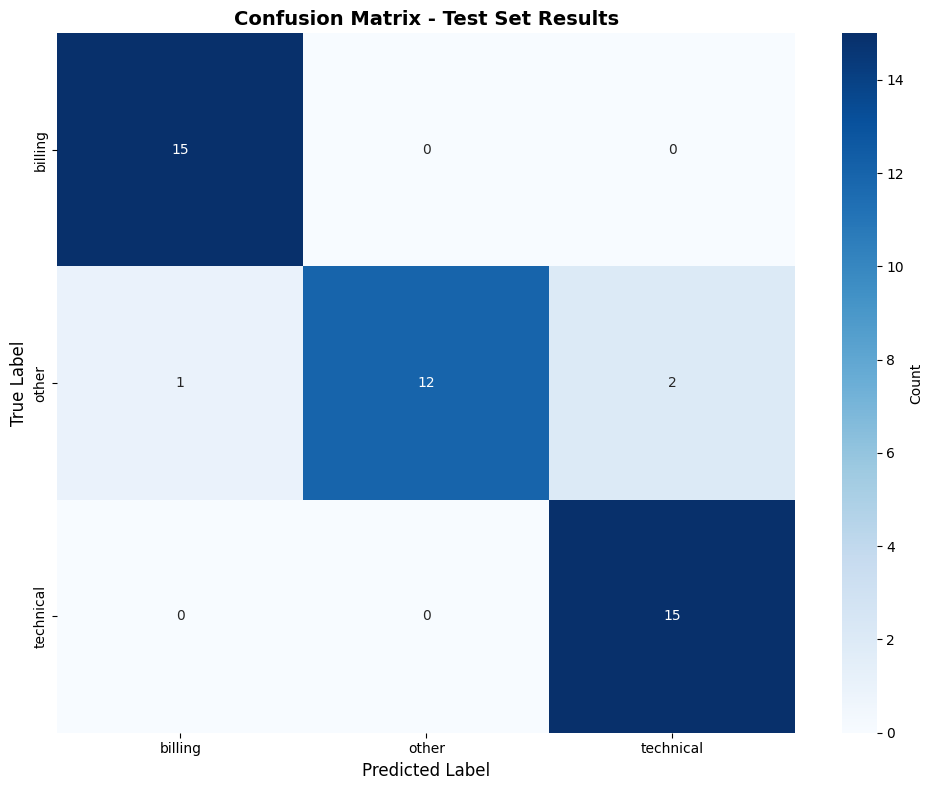

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label2id.keys()), 
            yticklabels=list(label2id.keys()),
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set Results', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [193]:
per_class_accuracy = {}
for label in label2id.keys():
    mask = np.array(y_true_labels) == label
    if mask.sum() > 0:
        per_class_accuracy[label] = (np.array(y_pred_labels)[mask] == label).mean()

print("\n🎯 PER-CLASS ACCURACY:")
for label, acc in per_class_accuracy.items():
    print(f"{label}: {acc:.3f} ({acc*100:.1f}%)")


🎯 PER-CLASS ACCURACY:
billing: 1.000 (100.0%)
other: 0.800 (80.0%)
technical: 1.000 (100.0%)


In [194]:
class OptimizedSupportTicketClassifier:
    def __init__(self, model_path="./support_ticket_classifier_optimized"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.model.eval()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
        # Text preprocessing function
        self.clean_text = lambda x: ' '.join(str(x).lower().strip().split())
        
    def predict(self, text: str, return_probs: bool = True):
        # Clean input text
        cleaned_text = self.clean_text(text)
        
        # Handle edge cases
        if not cleaned_text or len(cleaned_text) < 3:
            return {
                'predicted_label': 'Other',
                'confidence': 0.5,
                'all_probabilities': {'Billing': 0.33, 'Technical': 0.33, 'Other': 0.34},
                'warning': 'Text too short for reliable classification'
            }
        
        # Tokenize
        inputs = self.tokenizer(
            cleaned_text,
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors='pt'
        )
        
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            
            # Get probabilities with temperature scaling for better calibration
            temperature = 1.2  # Slightly higher temperature for small dataset
            probs = torch.softmax(logits / temperature, dim=-1)
            confidence, predicted_id = torch.max(probs, dim=-1)
            
            predicted_label = self.model.config.id2label[predicted_id.item()]
            confidence_score = confidence.item()
            
            result = {
                'predicted_label': predicted_label,
                'confidence': confidence_score
            }
            
            if return_probs:
                all_probs = {}
                for i, prob in enumerate(probs[0]):
                    label = self.model.config.id2label[i]
                    all_probs[label] = prob.item()
                result['all_probabilities'] = all_probs
                
            return result
    
    def predict_batch(self, texts: list):
        """Predict multiple texts at once for efficiency"""
        results = []
        for text in texts:
            results.append(self.predict(text))
        return results

# Initialize the optimized classifier
classifier = OptimizedSupportTicketClassifier()

# Comprehensive testing
test_examples = [
    # Billing examples
    "I was charged twice for my subscription this month",
    "Can I get a refund for the unused portion of my plan?", 
    "My credit card was declined, how do I update payment info?",
    "Why is my bill higher than expected?",
    
    # Technical examples
    "The application crashes when I try to upload files",
    "I can't login to my account, getting authentication error", 
    "The website is loading very slowly",
    "My data is not syncing across devices",
    
    # Other examples
    "How do I change my notification settings?",
    "What are your business hours?",
    "I'd like to learn about premium features",
    "Can you help me understand the dashboard?",
    
    # Edge cases
    "Hi",
    "Help me please",
    "Password reset",
]

print("🧪 COMPREHENSIVE PREDICTION TESTING:")
print("=" * 80)

for i, text in enumerate(test_examples, 1):
    result = classifier.predict(text)
    print(f"\n{i:2d}. Text: '{text}'")
    print(f"    Prediction: {result['predicted_label']} (confidence: {result['confidence']:.3f})")
    
    # Show top 2 probabilities
    sorted_probs = sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True)
    print(f"    Top probabilities: {sorted_probs[0][0]}={sorted_probs[0][1]:.3f}, {sorted_probs[1][0]}={sorted_probs[1][1]:.3f}")

🧪 COMPREHENSIVE PREDICTION TESTING:

 1. Text: 'I was charged twice for my subscription this month'
    Prediction: billing (confidence: 0.964)
    Top probabilities: billing=0.964, other=0.020

 2. Text: 'Can I get a refund for the unused portion of my plan?'
    Prediction: other (confidence: 0.845)
    Top probabilities: other=0.845, billing=0.136

 3. Text: 'My credit card was declined, how do I update payment info?'
    Prediction: billing (confidence: 0.898)
    Top probabilities: billing=0.898, other=0.084

 4. Text: 'Why is my bill higher than expected?'
    Prediction: billing (confidence: 0.891)
    Top probabilities: billing=0.891, other=0.090

 5. Text: 'The application crashes when I try to upload files'
    Prediction: technical (confidence: 0.911)
    Top probabilities: technical=0.911, other=0.072

 6. Text: 'I can't login to my account, getting authentication error'
    Prediction: technical (confidence: 0.817)
    Top probabilities: technical=0.817, other=0.160

 7. T